# Part 1: Data Querying

On the Data Team, one of our main vehicles for efficient data access is through our student
information system (SIS)’ backend. Demonstrate your knowledge of querying databases by
communicating the SQL query you would use for the following three tasks. Please use the
“KIPP Enrollment Data Model” shown on the following page. You do not need to reference the
spreadsheet for this Part 1:

![KIPP model](https://raw.githubusercontent.com/pscosta5/Personal-data-science-projects/master/School%20data/KIPP-model.PNG)

1. Return the unique count of all students enrolled at each school for the school year
2015–16 by Lunch Status

In [ ]:
# Use SQLite syntax

"""
WITH student_lunch AS
    (
    SELECT
        s.SSID,
        s.LunchStatus,
        e.SchoolYear
    FROM Students s
    INNER JOIN Enrollment e ON e.SSID = s.SSID
    )
    
SELECT
    LunchStatus,
    COUNT(DISTINCT(SSID)) number_of_students
FROM student_lunch
WHERE SchoolYear = '2015-2016'
GROUP BY LunchStatus
"""

# I'm assuming here that the column SchoolYear is in the format 20XX–20XX 
# as it in the attached spreadsheet

2. Return a list of all actively enrolled 6th grade students for the school year 2015-16 (hint:
enrollment statuses are flagged as ‘y’ and grades are stored as integers).

In [ ]:
"""
WITH student_grades AS
    (
    SELECT
        s.SSID,
        e.EnrollID,
        s.FullName,
        e.GradeLevel,
        e.EnrollStatus
    FROM Students s
    INNER JOIN Enrollment e ON e.SSID = s.SSID
    WHERE e.SchoolYear = '2015-2016'
    )

SELECT
    SSID,
    EnrollID,
    FullName
FROM student_grades
WHERE GradeLevel = 6 AND EnrollStatus = 'y'
"""

3. Create a view that captures all of a student’s school and demographic information, as
well as surface whether or not a student has attended more than one KIPP school for
the school year 15-16
    * List of Schools:
        - Elementary - KIPP Team, KIPP Respect
        - Middle - KIPP Justice
        - High - KIPP Courage

In [ ]:
# Using SQLite syntax
# Assuming we're only looking at students enrolled for the school year 2015–2016, and if they
# attended more than one KIPP school in the school year 2015–2016

"""
CREATE VIEW student_demo AS
    WITH school_counts AS
        (
        SELECT
            e.SSID,
            COUNT(DISTINCT(e.SchoolID)) school_count,
            s.SchoolID
        FROM School s
        INNER JOIN Enrollment e ON e.SchoolID = s.SchoolID
        WHERE e.SchoolYear = '2015-2016'
        GROUP BY e.SSID
        )

    SELECT
        st.*,
        sc.*,
        CASE
            WHEN s_c.school_count > 1 THEN 'y'
            ELSE 'n'
            END
            AS multiple_schools
    FROM Students st
    INNER JOIN Enrollment e ON e.SSID = st.SSID
    INNER JOIN School sc ON sc.SchoolID = e.SchoolID
    INNER JOIN school_counts s_c ON s_c.SSID = st.SSID
    WHERE e.SchoolYear = '2015-2016'
"""

# Part 2: Data QA

Operations Managers at each school collect student enrollment and exit information and enter it
into PowerSchool. Regionally, we conduct analyses on this data to help generate insights for
our School Leaders and Enrollment Taskforce. Prior to conducting an analysis, we perform a
quality control check on the data to identify if there’s anything problematic or concerning. With
this in mind, describe one data quality issue you’ve observed and explain why it may be
concerning (this isn’t meant to be an Easter Egg Hunt).

*(Data is on tabs labeled: ‘Enrollment...’)*

## Imports

In [34]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Data

[Spreadsheet for reference](https://docs.google.com/spreadsheets/d/13HG869V59xFTwZuwn2Yz8ILaXmi6QuXlyEDhIb5YNg8/edit?usp=sharing)

In [4]:
# Import all sheets into Pandas

enroll_dict = pd.read_excel('Work Sample_for Candidate_AD (2).xlsx', 
                            sheet_name='Enrollment Information',
                            skiprows=5)
lunch = pd.read_excel('Work Sample_for Candidate_AD (2).xlsx', 
                        sheet_name='Enrollment Lunch Status')
enroll = pd.read_excel('Work Sample_for Candidate_AD (2).xlsx', 
                        sheet_name='Enrollment Data')
sat_dict = pd.read_excel('Work Sample_for Candidate_AD (2).xlsx', 
                        sheet_name='SAT Information',
                        skiprows=6, usecols=2)
sat = pd.read_excel('Work Sample_for Candidate_AD (2).xlsx', 
                    sheet_name='SAT Data')
ter_dict = pd.read_excel('Work Sample_for Candidate_AD (2).xlsx', 
                         sheet_name='TER Information')
ter = pd.read_excel('Work Sample_for Candidate_AD (2).xlsx', 
                    sheet_name='TER Data')

Each row of data contains enrollment data for a student who currently attends or previously attended KIPP Bay Area Schools through the 2015–16 School year (i.e,. 1 row per student)

**NOTE: This reflects data since the beginning of time through the 15-16 School Year. Assume you're doing this analysis over the Summer of 15-16 and don't worry about 16-17 data.**

In [5]:
enroll_dict

,Fields,Description
0,School Name,School that the student exited from
1,StudentID,Unique Identifier for a student
2,grade_level,Student's current grade if they were still enr...
3,School Type,"Indicator of elementary, middle, or high"
4,Original KIPP Entrydate,The date the student first came to KIPP
5,ExitDate,The date the student exited KIPP. (Assume thos...
6,Ending School Year,The School Year in which the student exited.\n...
7,ExitCode,Exit code for student leaving KIPP
8,Still Enrolled (Y/N),Whether or not the student is still enrolled
9,NaN,NaN


In [6]:
enroll.head()

,School Name,StudentID,grade_level,School Type,Original KIPP Entry,ExitDate,Ending School Year,Number of Years at KIPP,ExitCode,Still Enrolled (Y/N)
0,KIPP Justice,6549,5,MS,2004-07-26 00:00:00,2004-12-10,2003-2004,1 Year or Less,(419) No Show,N
1,KIPP Justice,6739,5,MS,2004-11-18 00:00:00,2005-01-07,2004-2005,1 Year or Less,(419) No Show,N
2,KIPP Justice,3162,7,MS,2004-07-26 00:00:00,2006-09-10,2005-2006,2,(319) Transferred to another Public School,N
3,KIPP Justice,3158,6,MS,2004-07-26 00:00:00,2006-09-15,2005-2006,2,(119) Moved out of State,N
4,KIPP Respect,6707,7,MS,2005-09-06 00:00:00,2006-01-20,2005-2006,1 Year or Less,NaN,N


## Analysis

In [7]:
def convert_datetime(date):
    try:
        return pd.to_datetime(date)
    except Exception:
        return None

In [8]:
# Make a copy with datetime formats

enroll_datecheck = enroll.copy()
enroll_datecheck['ExitDate'] = pd.to_datetime(enroll['ExitDate'])
enroll_datecheck['Original KIPP Entry'] = enroll['Original KIPP Entry'].apply(convert_datetime)

In [9]:
# Find the missing values per column

enroll_datecheck.isnull().sum()

School Name                   0
StudentID                     0
grade_level                   0
School Type                   0
Original KIPP Entry          88
ExitDate                      0
Ending School Year            0
Number of Years at KIPP     109
ExitCode                   3850
Still Enrolled (Y/N)          0
dtype: int64

In [10]:
# For now drop missing values for analysis

enroll_datecheck = enroll_datecheck.dropna()

In [11]:
# Manually calculate time student spent in KIPP schools

enroll_datecheck['Calculated Time'] = enroll_datecheck['ExitDate'] - \
                                        enroll_datecheck['Original KIPP Entry']

## Solution

In [12]:
# Are any of the ExitDates before the Original KIPP Entry dates?

enroll_datecheck[enroll_datecheck['Calculated Time'] < datetime.timedelta(seconds=0)].head()

,School Name,StudentID,grade_level,School Type,Original KIPP Entry,ExitDate,Ending School Year,Number of Years at KIPP,ExitCode,Still Enrolled (Y/N),Calculated Time
29,KIPP Respect,6943,5,MS,2007-08-08,2007-08-07,2006-2007,1 Year or Less,(419) No Show,N,-1 days
30,KIPP Respect,6944,5,MS,2007-08-08,2007-08-07,2006-2007,1 Year or Less,(419) No Show,N,-1 days
31,KIPP Respect,6965,5,MS,2007-08-27,2007-08-07,2006-2007,1 Year or Less,(419) No Show,N,-20 days
32,KIPP Respect,6964,7,MS,2007-08-27,2007-08-13,2006-2007,1 Year or Less,(419) No Show,N,-14 days
33,KIPP Respect,6962,6,MS,2007-08-27,2007-08-22,2006-2007,1 Year or Less,(419) No Show,N,-5 days


### Findings

There are some mistakes in the dates listed in the data. Besides the number of invalid values in the `Original KIPP Entry` column, it seems that some of the listed dates in`ExitDate` come before the `Original KIPP
Entry` dates. Obviously, these are mistakes—as a student must enter a KIPP before leaving it.

# Part 3: Data Transformation

Because we work with so many varying data sources, we often spend a great deal of time
transforming data sets into a common format. Please perform as many of the following
transformations as you can, and if you’re using a scripted method (which is preferred but not
required) please include any scripts you used to transform data, as well as the transformed
data.

*(Data is on tabs labeled: ‘SAT...’)*

1. The data file currently has three fields containing IDs. Using these three fields, please
construct a single concatenated field that uniquely identifies each school (hint: ensure
that all IDs are of the same character length).

## Data

In [13]:
sat_dict

,Field,Type,Description
0,CO_CODE,Char,County code
1,DIST_CODE,Char,District code
2,SCH_CODE,Char,School code
3,TOTAL,Alphanumeric,Composite SAT Score
4,MATHEMATICS,Alphanumeric,Mathematics average score.
5,CRITICAL_READING,Alphanumeric,Verbal average score.
6,WRITING,Alphanumeric,Essay average score.
7,SAT_1550,Alphanumeric,% of students scoring above 1550


In [14]:
sat.head()

,CO_CODE,DIST_CODE,SCH_CODE,TOTAL,MATHEMATICS,CRITICAL_READING,WRITING,SAT_1550
0,1,110,10,1320,461,429,430,23.5
1,1,120,10,1502,515,506,481,41.7
2,1,590,25,1418,486,468,464,31.1
3,1,1310,5,1479,504,490,485,37.8
4,1,1790,40,1477,508,486,483,35.7


## Transformation

In [15]:
# Convert the three id fields to strings

id_fields = ['CO_CODE', 'DIST_CODE', 'SCH_CODE']
for col in id_fields:
    sat[col] = sat[col].astype(str)

In [16]:
# Checking the length of the codes for each column

sat['CO_CODE'].apply(len).value_counts()

2    288
1    106
Name: CO_CODE, dtype: int64

In [17]:
sat['DIST_CODE'].apply(len).value_counts()

4    337
3     57
Name: DIST_CODE, dtype: int64

In [18]:
sat['SCH_CODE'].apply(len).value_counts()

2    352
3     28
1     14
Name: SCH_CODE, dtype: int64

In [19]:
# Add leading 0s

def add_0s(code, length):
    while len(code) < length:
        code = "0" + code
    return code

In [20]:
sat['CO_CODE'] = sat['CO_CODE'].apply(lambda code: add_0s(code, 2))
sat['DIST_CODE'] = sat['DIST_CODE'].apply(lambda code: add_0s(code, 4))
sat['SCH_CODE'] = sat['SCH_CODE'].apply(lambda code: add_0s(code, 3))

In [21]:
# Make unique ID column

sat['ID'] = sat['CO_CODE'] + sat['DIST_CODE'] + sat['SCH_CODE']

In [22]:
sat.columns.tolist()

['CO_CODE',
 'DIST_CODE',
 'SCH_CODE',
 'TOTAL',
 'MATHEMATICS',
 'CRITICAL_READING',
 'WRITING',
 'SAT_1550',
 'ID']

## Solution

In [23]:
# Change order of new ID column so it comes first
new_column_order = ['ID',
                    'CO_CODE',
                     'DIST_CODE',
                     'SCH_CODE',
                     'TOTAL',
                     'MATHEMATICS',
                     'CRITICAL_READING',
                     'WRITING',
                     'SAT_1550']
sat = sat[new_column_order]
sat.head(10)

,ID,CO_CODE,DIST_CODE,SCH_CODE,TOTAL,MATHEMATICS,CRITICAL_READING,WRITING,SAT_1550
0,010110010,01,0110,010,1320,461,429,430,23.5
1,010120010,01,0120,010,1502,515,506,481,41.7
2,010590025,01,0590,025,1418,486,468,464,31.1
3,011310005,01,1310,005,1479,504,490,485,37.8
4,011790040,01,1790,040,1477,508,486,483,35.7
5,011790050,01,1790,050,1371,470,454,447,25.5
6,011790060,01,1790,060,1403,471,464,468,34.7
7,011960050,01,1960,050,1522,519,506,497,41.2
8,012910050,01,2910,050,1531,529,504,498,47.4
9,014180050,01,4180,050,1135,395,363,377,4.3


In [24]:
# Export to sheet for viewing

writer = pd.ExcelWriter('unique_id.xlsx')
sat.to_excel(writer, 'SAT Data', index=False)
writer.close()

#### **[Full sheet may be viewed here](https://docs.google.com/spreadsheets/d/1K7xBRPyHpgKmP0Dud7_6Eg8l7L5qr6SJnRqhI0-AUVQ/edit?usp=sharing)**
https://docs.google.com/spreadsheets/d/1K7xBRPyHpgKmP0Dud7_6Eg8l7L5qr6SJnRqhI0-AUVQ/edit?usp=sharing

2. The current file is stored in what is sometimes called wide format, where repeating
values are stored in individual columns and rows are non-repeating. Please transform
the file into long format, where schools would have multiple rows per school and
columns would indicate ID, DATA_TYPE, and VALUE. For example:

![KIPP transform](https://raw.githubusercontent.com/pscosta5/Personal-data-science-projects/master/School%20data/KIPP-transform.PNG)

In [25]:
sat.head()

,ID,CO_CODE,DIST_CODE,SCH_CODE,TOTAL,MATHEMATICS,CRITICAL_READING,WRITING,SAT_1550
0,010110010,01,0110,010,1320,461,429,430,23.5
1,010120010,01,0120,010,1502,515,506,481,41.7
2,010590025,01,0590,025,1418,486,468,464,31.1
3,011310005,01,1310,005,1479,504,490,485,37.8
4,011790040,01,1790,040,1477,508,486,483,35.7


In [26]:
value_cols = ['TOTAL', 'MATHEMATICS', 'CRITICAL_READING', 'WRITING', 'SAT_1550']
sat_long = pd.melt(sat, id_vars=['ID'], value_vars=value_cols, var_name='DATA_TYPE', 
                   value_name='VALUE')

## Solution

In [27]:
sat_long = sat_long.sort_values('ID')
sat_long.head(10)

,ID,DATA_TYPE,VALUE
0,010110010,TOTAL,1320.0
394,010110010,MATHEMATICS,461.0
1576,010110010,SAT_1550,23.5
788,010110010,CRITICAL_READING,429.0
1182,010110010,WRITING,430.0
1,010120010,TOTAL,1502.0
395,010120010,MATHEMATICS,515.0
1577,010120010,SAT_1550,41.7
1183,010120010,WRITING,481.0
789,010120010,CRITICAL_READING,506.0


In [28]:
# Export to sheet for viewing

writer = pd.ExcelWriter('long_data.xlsx')
sat_long.to_excel(writer, 'SAT Data', index=False)
writer.close()

#### **[Full sheet may be viewed here](https://docs.google.com/spreadsheets/d/1tMw5OAlxle3JgkT7OLiWH41LMc1UYIg6ywNISGYkQrg/edit?usp=sharing)**

https://docs.google.com/spreadsheets/d/1tMw5OAlxle3JgkT7OLiWH41LMc1UYIg6ywNISGYkQrg/edit?usp=sharing

# Part 4: Data Visualization (Tableau preferred) and Communication

At KBAS, we use a Teaching Excellence Rubric (TER) to coach our teachers. The rubric has
five different domains, including Individualized Learning, Culture of Learning, Essential Content,
Academic Ownership and Demonstration of Learning, each of which includes a unique set of
indicators. 17-18 was our first year of using a platform called Whetstone to track teacher
observations utilizing the TER. Explore our mock Quarter 3 Teacher Observation data, creating
a visualization in Tableau of your findings. Please include your data visualization end product (if
in Tableau, please also include a screenshot in case we have a different version), as well as a
brief write-up addressed to our Chief Academic Officer about what you observe, noting any
interesting things you’re seeing.

Note that on the Data Team we are often asked to perform exploratory analysis with very robust,
though sometimes limited data sets. And because many of our stakeholders are mostly
non-technical folks, surfacing our insights for them in clear, concise, and compelling data
visualizations works best.

*(Data is on tabs labeled: ‘TER...’)*

## Data

In [29]:
ter_dict

,Rubric Form,Metric Definitions
0,KBAS TER by Domain,"Scores are at the Domain Level (1,2,3,4,5)"
1,KBAS TER by Indicator,"Scores are at the Indicator Level (1.1, 1.2, 1..."
2,KBAS Math Focused Teaching Excellence Rubric,Scores are for Math focus areas and can be at ...
3,KBAS ELA Focused Teaching Excellence Rubric,Scores are for ELA focus areas and can be at e...
4,NaN,NaN
5,*Scores ranges from 1-4,NaN


In [30]:
ter.head()

,Observee,Observer,School,Grade,Class,Obs. Date,Form,Score,"2. Culture of Learning: Are all students taking ownership over creating a purposeful, joyful and challenging learning environment?","1. Individualized Learning: Are all students receiving differentiated instruction based on their unique academic and social and emotional needs? Does instruction take individual student’s interests, motivations and identity into account?",...,3.1L - Daily lesson planning,4.1L - Students do the heavy lifting,3.5 - Intentional pacing,3.4 - Rigorous instructional materials,5.1L - Checks for understanding during the lesson,6.3- Professionalism,6.5 - Renew to get stronger,4.1 - Students do the heavy lifting,5.4m - Students on track to achieve learning goals,1.1L - Differentiated and individualized materials
0,Teacher 01,Observer 02,KIPP Tunnel (Lower),3rd grade,Math,2017-11-30 09:40 PST,KBAS Math Focused Teaching Excellence Rubric,2.91,-,-,...,-,-,-,-,-,-,-,-,3,-
1,Teacher 02,Observer 03,KIPP Tunnel (Lower),4th grade,ELA,2017-11-30 08:54 PST,KBAS ELA Focused Teaching Excellence Rubric,2.00,-,-,...,2,-,-,-,-,-,-,-,-,-
2,Teacher 02,Observer 02,KIPP Tunnel (Lower),4th grade,ELA,2017-11-30 10:52 PST,KBAS ELA Focused Teaching Excellence Rubric,2.50,-,-,...,3,3,-,-,2,-,-,-,-,2
3,Teacher 03,Observer 04,KIPP Ocean,5th grade,Math,2017-09-08 10:06 PDT,KBAS TER by Domain,2.33,2,2,...,-,-,-,-,-,-,-,-,-,-
4,Teacher 03,Observer 05,KIPP Ocean,5th grade,Math,2017-09-12 10:00 PDT,KBAS TER by Domain,2.33,3,2,...,-,-,-,-,-,-,-,-,-,-


In [31]:
# Replace - with proper NaN
ter = ter.replace('-', np.nan)

# Date to datetime
ter['Obs. Date'] = pd.to_datetime(ter['Obs. Date'])

C:\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


## Exploratory analysis

### Scores

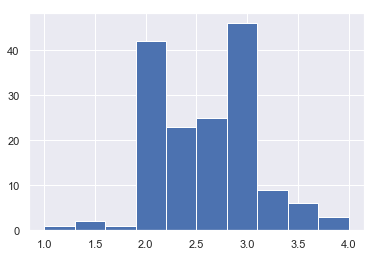

In [35]:
# Look at distribution of scores

ter['Score'].hist()

### Scores by class

In [92]:
# Isolate only the question columns

question_columns = [i for i in range(8, 65)]
questions = ter.columns[question_columns]

In [93]:
# Group results by class type and transpose data

subject_questions = ter.groupby('Class')[questions].mean().dropna(axis=1).transpose()

In [94]:
# Find questions with the biggest score difference between class types

subject_questions['difference'] = abs(subject_questions['ELA'] - subject_questions['Math'])

In [95]:
# Plot the 10 biggest difference questions

subject_questions = subject_questions.sort_values('difference', ascending=False) \
                    .drop(columns='difference').iloc[:10]

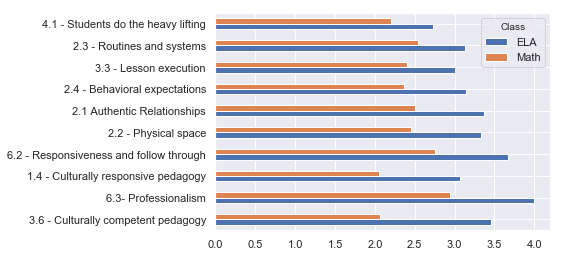

In [99]:
subject_questions = subject_questions.rename({
    subject_questions.index[3]: '6.2 - Responsiveness and follow through',
    subject_questions.index[8]: '2.3 - Routines and systems'
})
subject_questions.plot.barh()

### Correlation to overall score

In [57]:
# Find correlations between the total score and other columns

score_corr = ter.corr()['Score'].drop('Score')

In [58]:
# Find questions with the highest and lowest correlation to overall score

score_corr_plot = score_corr[(score_corr < 0.36) | (0.85 < score_corr)]

In [100]:
# Rename questions for better plotting
score_corr_plot = score_corr_plot.rename({score_corr_plot.index[0]: "1. Individualized Learning",
                                         score_corr_plot.index[7]: "6.2 - Responsiveness and follow through"})

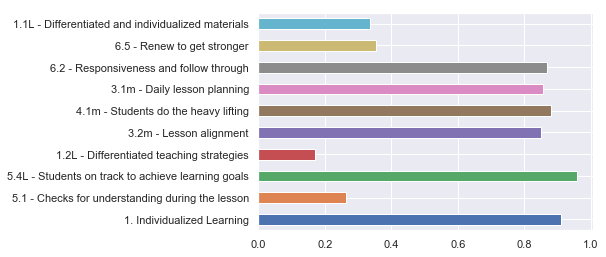

In [101]:
score_corr_plot.plot.barh()

### Scores by school

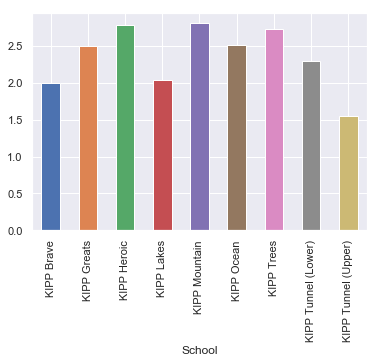

In [45]:
# Find average score by school

ter.groupby('School')['Score'].mean().plot.bar()

## Solution

#### **[Data visualization end product may be viewed here](https://colab.research.google.com/drive/1SryJ9H8ECL352WbHHdN7BJWwlOHB72rJ)**

https://colab.research.google.com/drive/1SryJ9H8ECL352WbHHdN7BJWwlOHB72rJ

### Score distribution
The scores are not normally distributed, but this is likely due to the grading system itself—as teachers are often awarded integer scores.

There is a difference in the average score of different schools. However, the review count for some schools—such as `Kipp Tunnel (Upper)`—is too low to make meaningful comparisons without more data.

### Scores by class
There is a noticeable difference in how observers score teachers of different classes (math or ELA). We find that ELA classes consistently receive higher scores.

### Correlation to the overall score
This chart plots the correlation of individual questions to the teacher’s overall score. Some questions, such as `5.4L – Students on track to achieve learning goals` are highly correlated to the overall teacher score. Other evaluation prompts, such as `1.2L – Differentiated teaching strategies` and `5.1 – Checks for understanding during the lesson` have very low correlations with the overall teacher score.

# Part 5: Project Management

In the upcoming year, we would like to delve more deeply into our Whetstone classroom
observation data with the goal of helping us understand how well our region is growing its
teachers. Please put together a brief project plan showing how you would approach that project,
outlining the key steps, potential stakeholders, responsibilities and timing. Use the visualization
exercise in Part 4 to inform your project plan.

## Project plan

The purpose of observation data is to provide a measurable metric that teachers and schools may improve upon. To understand how KIPP is growing its teachers, I would
1. Evaluate the relevance of the Whetstone data
2. Create groups with Whetstone score differences
3. Reveal the cause for differences in scores

Stakeholders for the project would be management, teachers, and KIPP students themselves. In a team of three people, one member would be in charge of cleaning the data—ensuring that we can match up teacher scores with their information and with the students they have taught. The remaining two would work on grouping the teacher-focused and student-focused data, respectively. The groupings that come out of these studies would be split among team members for the final step 3 analysis.

The goal of the project would be to find out why certain teachers perform better on Whetstone evaluations. This knowledge would allow us to better support our teachers and to provide a better learning environment for our students. The project would result in data that highlights the strengths and weaknesses of the program and lead to actionable steps to improving KIPP’s effectiveness.

### 1 – How relevant is the Whetstone data?
#### 1–3 weeks
Since the Whetstone data is the cornerstone of this project, it’s relevance will be evaluated. More data corresponding to student’s grades, standardized test scores, and other evaluations would be merged in. We would study the correlation between the Whetstone evaluation data and a student’s performance to understand how we should value the observation data.

The `Scores by class` plot reveals that there is a scoring bias depending on the type of class observed. It’s worth exploring whether different classes/subjects should be evaluated differently. We might need to value different questions on the observation data more or less depending on the class. A simple model on the effects of each question to the overall score will be made to identify the key aspects that make an effective teacher.

Likewise, the `Correlation to total score` plot reveals that some evaluation points are highly correlated to a teacher’s overall score, while some have a somewhat low correlation. A key result of this step is to identify what metrics we should value when measuring teacher performance. At the conclusion of this step, we should have a list of which metrics we deem most valuable, and will be using them to evaluate performance for the rest of the project.

### 2 – Revealing differences in scores
#### 1–1.5 weeks
As the `Average score per school` plot reveals, some schools perform better on Whetstone evaluations. A similar analysis would reveal other groupings that result in an observation score gap. If there is enough data over a long enough period of time, I would also like to analyze if teachers’ scores are significantly changing over time. We would study the rate of change—seeing if specific schools or groups have a higher improvement rate.

If teacher data is available—such as their salary, years teaching, years at KIPP, etc—it would be also merged in at this point to create groupings of teachers with different attributes. Likewise, student-focused data—such as their demographics, grades, scores, etc—would be merged in and similarly evaluated. This step would result in many groupings of different observation scores, which we can dive into in our final project step.


### 3 – Finding the cause of these differences
#### 2–4 weeks
After we organize and group the data, we would delve into why certain groups are evaluated differently. For example, we would look at why  KIPP Lakes lags behind KIPP Heroic in observation scores. We would attempt to identify what high performing schools have in common in order to root out the cause of their score differences.

Likewise, it is worth looking at individual data of high-performance teachers. We will study teachers with high observation scores and teachers who have improved their scores. We would look into what specific aspect they improved, and if it affected their colleagues and students. Data such as this can not only help us support current teachers, but identify positive traits for future hirings.

Finding out the causes of different evaluation scores would allow us to understand how our teachers are growing and how we can best support them.